In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import lightgbm as lgb
import re

In [8]:
# データ読み込み
normal_data = pd.read_csv('normal_features_5_light_srs.csv')
abnormal_data = pd.read_csv('anormal_features_5_light.csv')

# 正常ラベル=0,異常ラベル=1
normal_data['label'] = 0
abnormal_data['label'] = 1
data = pd.concat([normal_data, abnormal_data], ignore_index=True)

# 特徴量とターゲット,特徴名リスト
X = data.drop(['hashvin', 'total_ig_cycle', 'label'], axis=1)
y = data['label']
feature_names = X.columns.tolist()

# 基本情報
num_features = X.shape[1]
num_normal = normal_data.shape[0]
num_abnormal = abnormal_data.shape[0]
total_samples = num_normal + num_abnormal
print(f"特徴量の総数: {num_features}")
print(f"正常サンプル数: {num_normal}")
print(f"異常サンプル数: {num_abnormal}")
print(f"合計サンプル数: {total_samples}")
print(f"特徴量の総数/合計サンプル: {num_features/total_samples*100:.2f}%")
print(f"正常サンプル/異常サンプル: {num_normal/num_abnormal}")

# 特徴量とターゲット変数の分割
X = data.drop(['hashvin', 'total_ig_cycle', 'label'], axis=1)
y = data['label']

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 不均衡対策: クラスインバランス重みづけ
class_counts = y.value_counts()
weights = 1.0 / class_counts
weights = weights / weights.sum()
class_weights = {i: w for i, w in enumerate(weights)}

# 全故障データのインデックス取得
abnormal_indices = y[y == 1].index

特徴量の総数: 162
正常サンプル数: 768
異常サンプル数: 15
合計サンプル数: 783
特徴量の総数/合計サンプル: 20.69%
正常サンプル/異常サンプル: 51.2


In [3]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'objective': 'binary', #binary,cross_entropy
        'metric': ['binary_logloss', 'binary_error'], #recall監視のため消しても良い
        'num_leaves': trial.suggest_int('num_leaves', 2**7, 2**9),
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': 20,
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-1, 10, log=True),
        'reg_lambda': 0.0,
        'class_weight': None, #balanced
        'scale_pos_weight': num_normal / num_abnormal, #def=1
        'random_state': 42,
        'verbose': -1
    }
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    recalls = []
    for train_index, test_index in kf.split(X_scaled[abnormal_indices], y.iloc[abnormal_indices]):
        X_test = X_scaled[abnormal_indices[test_index]]
        y_test = y.iloc[abnormal_indices[test_index]]
        
        train_indices = list(set(range(len(X_scaled))) - set(abnormal_indices[test_index]))
        X_train = X_scaled[train_indices]
        y_train = y.iloc[train_indices]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
        
        evals_result = {}
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            valid_names=['train', 'valid'],
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False), lgb.record_evaluation(evals_result)],
            feval=lambda preds, train_data: ('recall', recall_score(train_data.get_label(), preds > 0.5), True)
        )
        
        preds = model.predict(X_test)
        preds = (preds > 0.5).astype(int)
        recall = recall_score(y_test, preds)
        recalls.append(recall)
    
    mean_recall = np.mean(recalls)
    
    return mean_recall


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use

{'num_leaves': 231, 'max_depth': 12, 'learning_rate': 0.07325893804508404, 'n_estimators': 492, 'reg_alpha': 0.27609648341947646}


Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument



Average Precision: 1.0000
Average Recall: 0.9500
Average F1-score: 0.9667

Average Feature Importances (Top 20):
Feature: ave_trip_len, Importance: 18292.1313
Feature: ig_freq_time, Importance: 2165.6980
Feature: INTA_ini, Importance: 64.2525
Feature: INTA_EV_SD, Importance: 14.1344
Feature: ave_run_distance, Importance: 1.4195
Feature: Ne_stop_sum, Importance: 0.0000
Feature: Vp_driv_sum, Importance: 0.0000
Feature: Vp_driv_max, Importance: 0.0000
Feature: Ne_stop_max, Importance: 0.0000
Feature: Vp_p_driv_sum, Importance: 0.0000
Feature: Vp_p_driv_max, Importance: 0.0000
Feature: Vp_stop_sum, Importance: 0.0000
Feature: Vp_stop_max, Importance: 0.0000
Feature: Vp_p_stop_sum, Importance: 0.0000
Feature: Vp_p_stop_max, Importance: 0.0000
Feature: Ne_p_stop_max, Importance: 0.0000
Feature: Ne_driv_sum, Importance: 0.0000
Feature: Ne_driv_max, Importance: 0.0000
Feature: Ne_p_driv_sum, Importance: 0.0000
Feature: Ne_p_driv_max, Importance: 0.0000


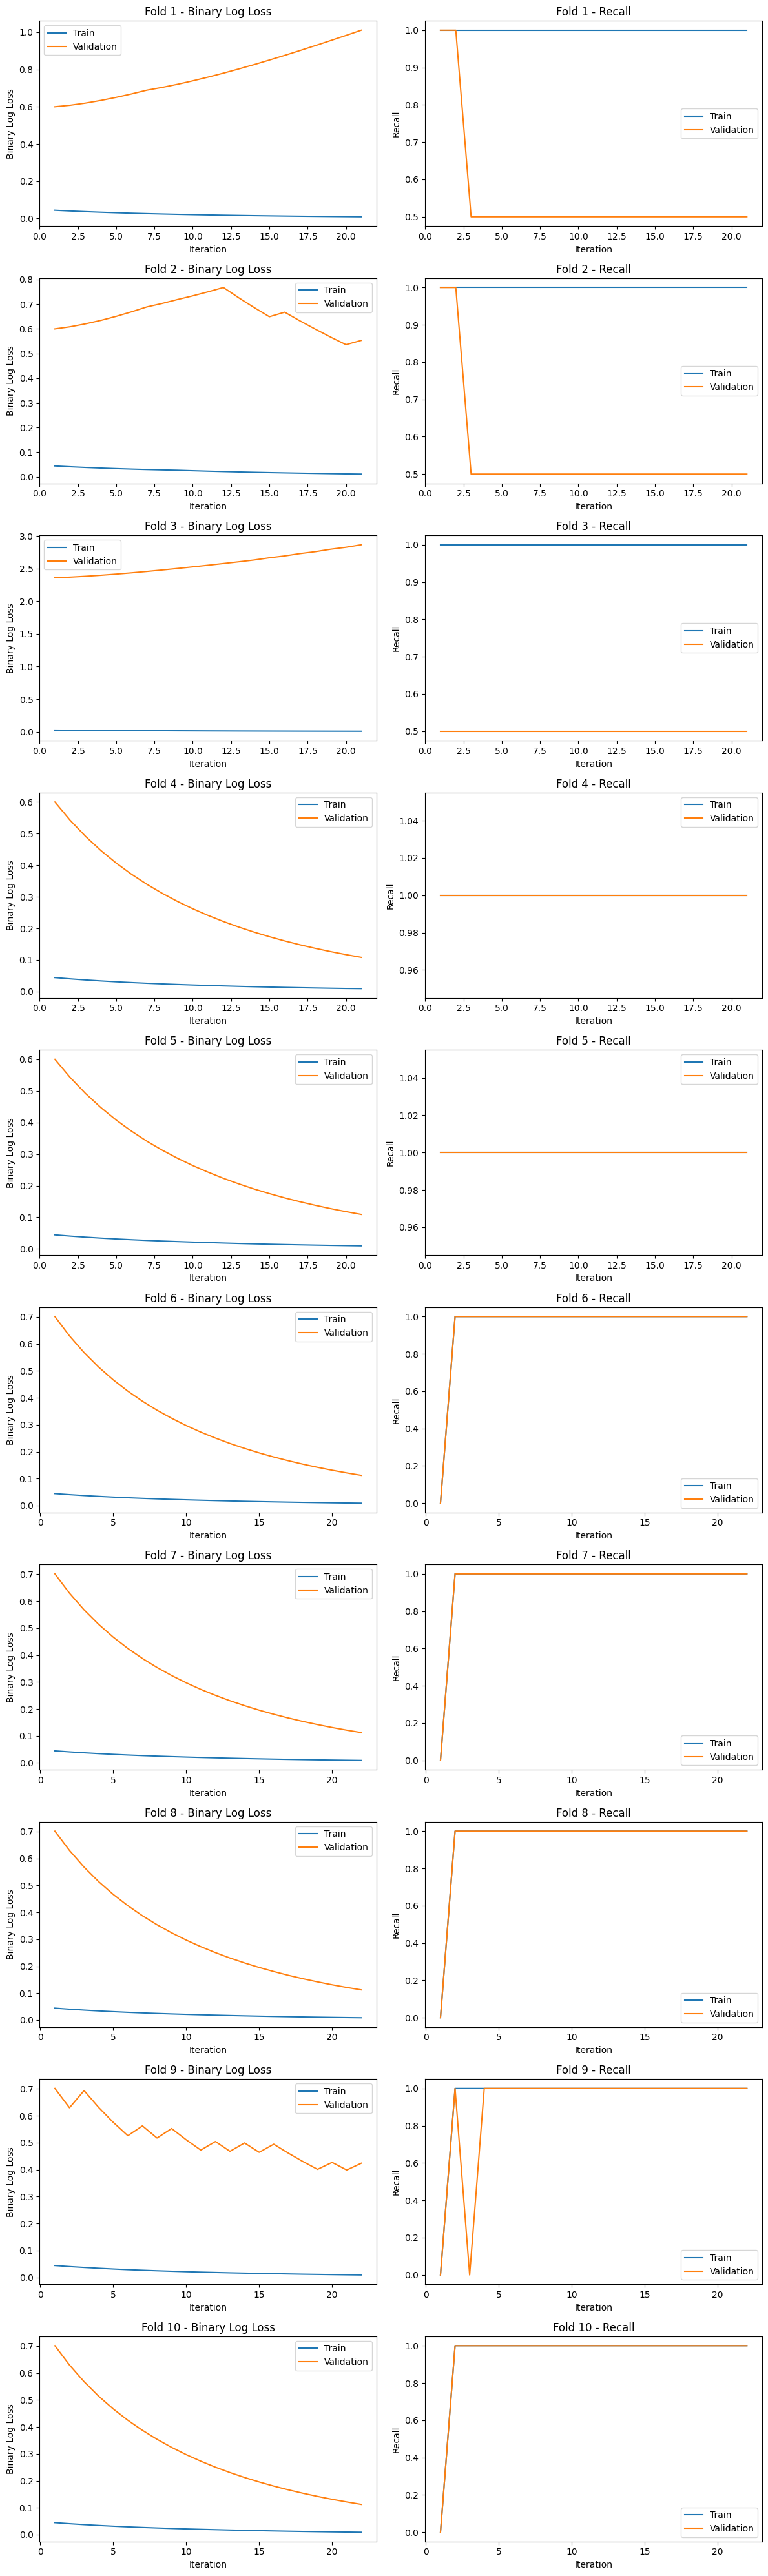

In [4]:
# 最適パラメータ
best_params = study.best_params
print(best_params)

opt_params = {
    'objective': 'binary', 
    'metric': ['binary_logloss'], #recall監視のため消しても良い
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'reg_lambda': 0.0,
    'class_weight': None,
    'scale_pos_weight': num_normal / num_abnormal,
    'random_state': 42,
    'verbose': -1,
    **best_params
}

# k-fold Cross Validation
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 各フォールドの結果を格納するリスト
fold_results = []

# 学習曲線のプロット用のデータを格納するリスト
train_loss_curves = []
valid_loss_curves = []
train_recall_curves = []
valid_recall_curves = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled[abnormal_indices], y.iloc[abnormal_indices]), start=1):
    X_test = X_scaled[abnormal_indices[test_index]]
    y_test = y.iloc[abnormal_indices[test_index]]
    train_indices = list(set(range(len(X_scaled))) - set(abnormal_indices[test_index]))
    X_train = X_scaled[train_indices]
    y_train = y.iloc[train_indices]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    evals_result = {}
    model = lgb.train(
        opt_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False), lgb.record_evaluation(evals_result)],
        feval=lambda preds, train_data: ('recall', recall_score(train_data.get_label(), preds > 0.5), True)
    )
    
    preds = model.predict(X_test)
    preds = (preds > 0.5).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    importances = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    fold_results.append({
        'fold': fold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'importance_df': importance_df
    })
    
    # 学習曲線データの記録
    train_loss_curves.append(evals_result['train']['binary_logloss'])
    valid_loss_curves.append(evals_result['valid']['binary_logloss'])
    train_recall_curves.append(evals_result['train']['recall'])
    valid_recall_curves.append(evals_result['valid']['recall'])

# 評価指標の平均値計算
avg_precision = np.mean([result['precision'] for result in fold_results])
avg_recall = np.mean([result['recall'] for result in fold_results])
avg_f1 = np.mean([result['f1'] for result in fold_results])

# 重要度の平均値計算
avg_importance = pd.concat([result['importance_df'].set_index('feature') for result in fold_results], axis=1).mean(axis=1).reset_index()
avg_importance.columns = ['feature', 'importance']
avg_importance = avg_importance.sort_values('importance', ascending=False).head(20)

# 評価指標の表示
print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

# 重要度の表示
print("\nAverage Feature Importances (Top 20):")
for _, row in avg_importance.iterrows():
    print(f"Feature: {row['feature']}, Importance: {row['importance']:.4f}")

# 学習曲線のプロット
metrics = ['Binary Log Loss', 'Recall']
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 4*n_splits))

for fold in range(n_splits):
    for i, metric in enumerate(metrics):
        if metric == 'Binary Log Loss':
            train_data = train_loss_curves[fold]
            valid_data = valid_loss_curves[fold]
        else:
            train_data = train_recall_curves[fold]
            valid_data = valid_recall_curves[fold]
        
        iterations = range(1, len(train_data) + 1)
        axes[fold, i].plot(iterations, train_data, label='Train')
        axes[fold, i].plot(iterations, valid_data, label='Validation')
        axes[fold, i].set_ylabel(metric)
        axes[fold, i].set_xlabel('Iteration')
        axes[fold, i].set_title(f"Fold {fold+1} - {metric}")
        axes[fold, i].legend()

plt.tight_layout()
plt.show()

Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


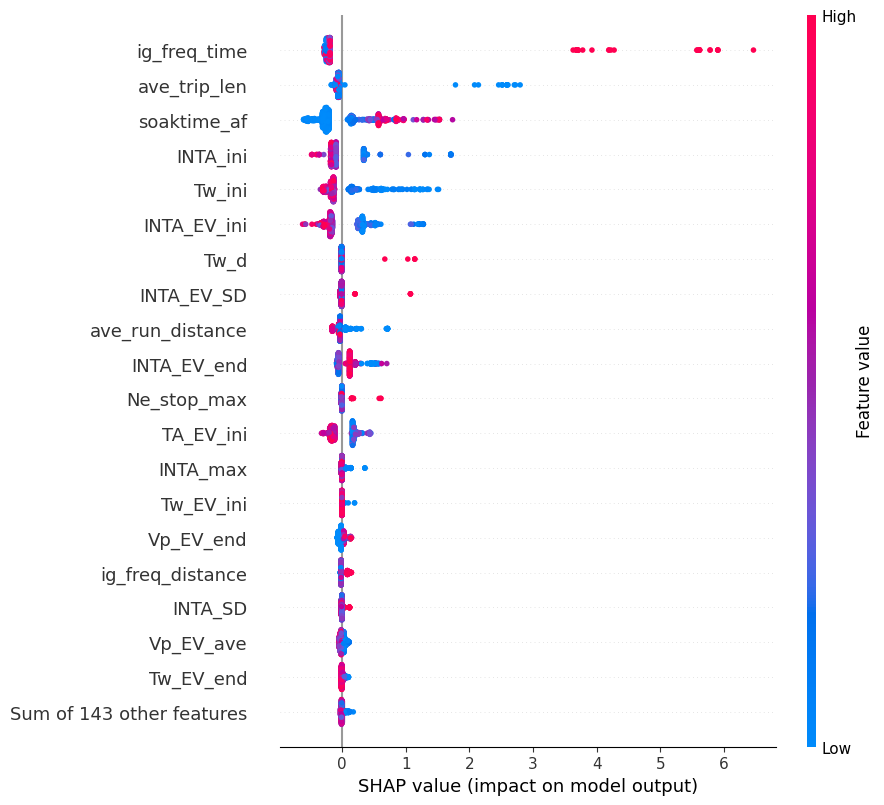

<Figure size 640x480 with 0 Axes>

In [5]:
X_train = X_scaled
Y_train = y
X_test = X_scaled
Y_test = y

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

model = lgb.train(opt_params, lgb_train, valid_sets=lgb_test)  

# tree explainerの初期化
explainer = shap.TreeExplainer(model)

# 異常データでshap値を計算  
shap_values = explainer.shap_values(X_test)

# beeswarm plot
shap.initjs()
target_class = 1
shap_exp = shap.Explanation(shap_values[target_class], feature_names=feature_names,data=X_test)
shap.plots.beeswarm(shap_exp,max_display=20, order=shap_exp.abs.max(0))
plt.tight_layout()
plt.show()


Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


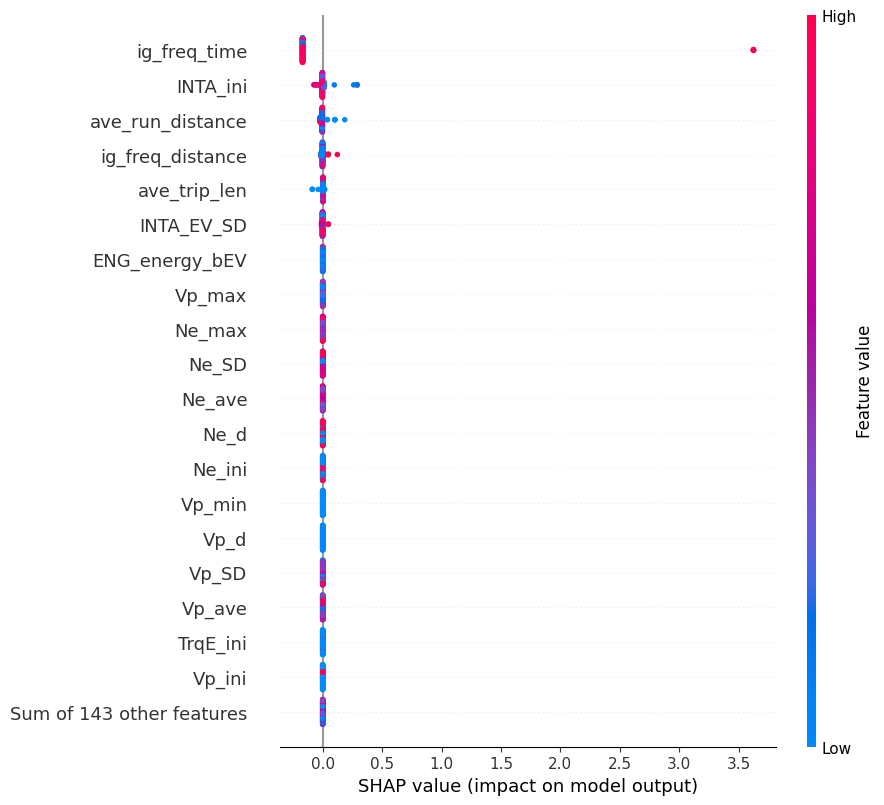

<Figure size 640x480 with 0 Axes>

Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


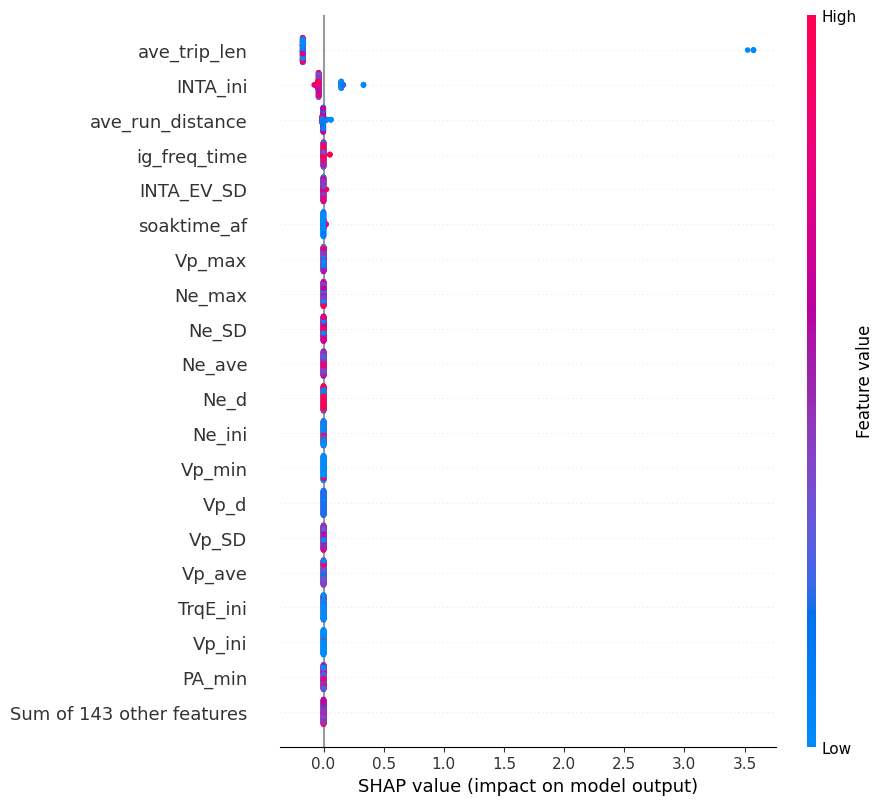

<Figure size 640x480 with 0 Axes>

Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


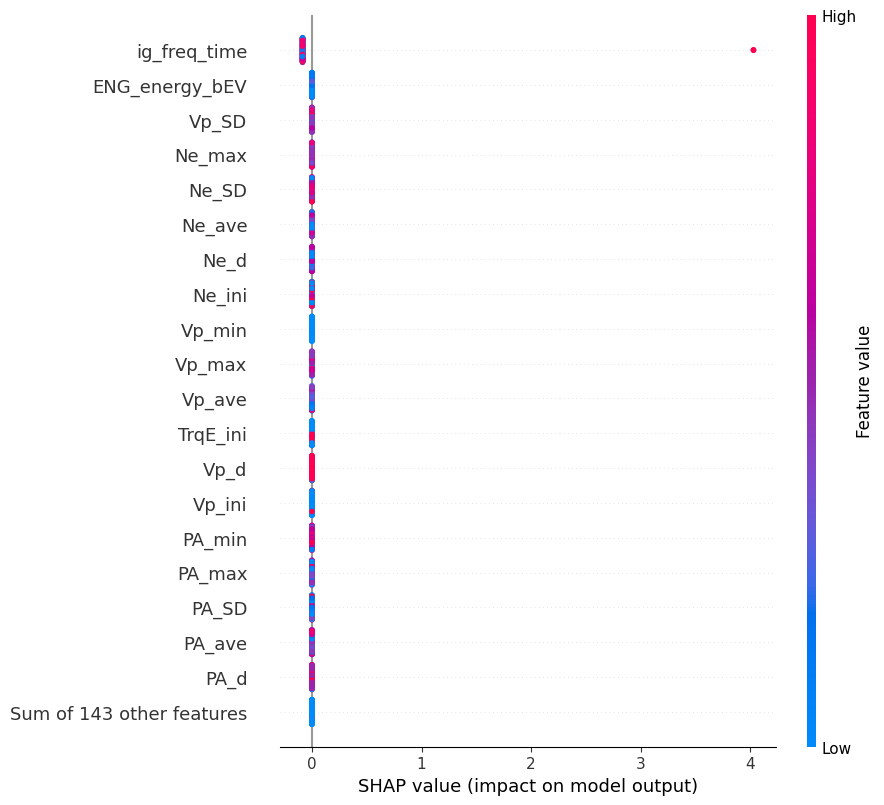

<Figure size 640x480 with 0 Axes>

Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


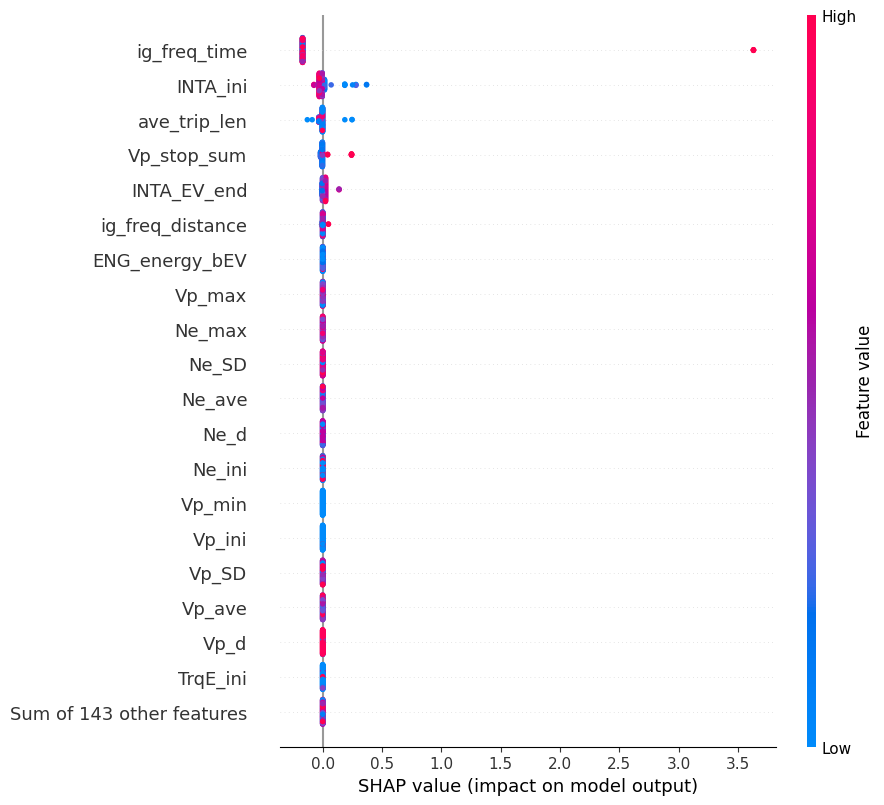

<Figure size 640x480 with 0 Axes>

Found `n_estimators` in params. Will use it instead of argument
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


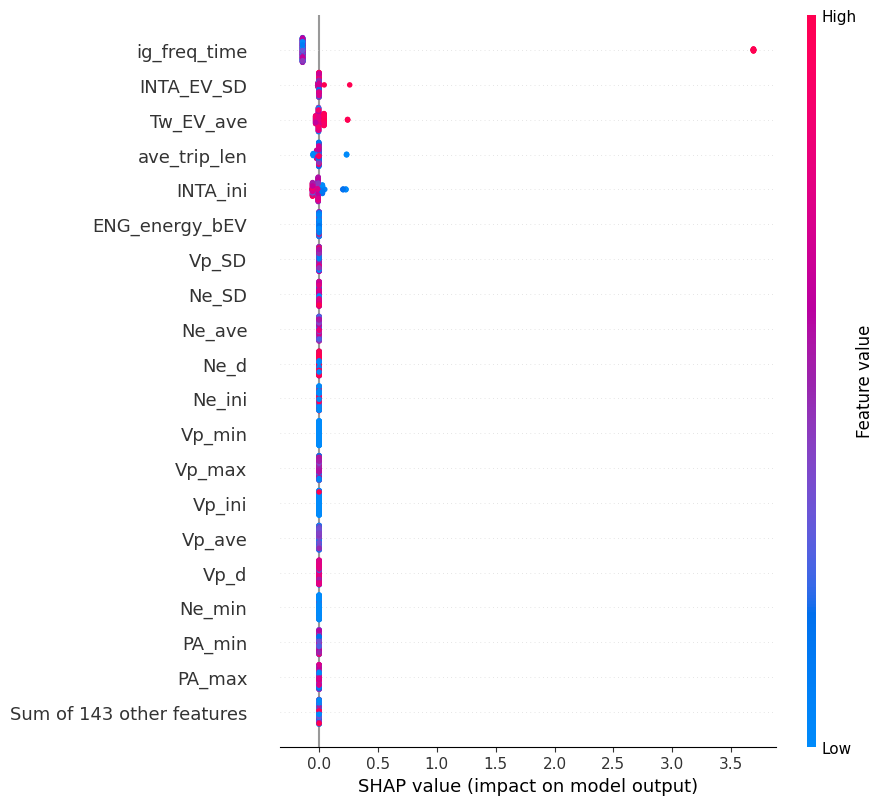

<Figure size 640x480 with 0 Axes>

In [6]:
n_splits = 5
fold_shap_values = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), start=1):
    X_test = X_scaled[test_index]
    y_test = y.iloc[test_index]
    X_train = X_scaled[train_index]
    y_train = y.iloc[train_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    model = lgb.train(opt_params, lgb_train, valid_sets=lgb_test,
                      callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False), lgb.record_evaluation(evals_result)],
                      feval=lambda preds, train_data: ('recall', recall_score(train_data.get_label(), preds > 0.5), True)
                      ) 

    # tree explainerの初期化
    explainer = shap.TreeExplainer(model)

    # テストデータでshap値を計算  
    shap_values = explainer.shap_values(X_test)

    # beeswarm plot
    shap.initjs()
    target_class = 1
    shap_exp = shap.Explanation(shap_values[target_class], feature_names=feature_names, data=X_test)
    shap.plots.beeswarm(shap_exp, max_display=20, order=shap_exp.abs.max(0))
    plt.tight_layout()
    plt.show()

    fold_shap_values.append(shap_values)
